In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import hydra

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hydra.initialize(config_path="cfg_flexible", version_base=None)

hydra.initialize()

In [2]:

from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm


cfg = hydra.compose(config_name="config", overrides=["task=KS_short", "nt=14"])

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde'][:1000, :131:10], dtype=torch.float32)

In [4]:
print(traj.shape)

torch.Size([1000, 14, 1, 256])


In [5]:

from neuralop.models import FNO

nt = cfg.nt
ensemble_size = cfg.ensemble_size
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = 128

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=cfg.model.n_modes, hidden_channels=64,
                in_channels=1, out_channels=1)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

Y = traj.to(device).squeeze(2)
train_nts = torch.zeros(Y.shape[0], device=device).long()
train_nts[:initial_datasize] = nt

model = train(Y[:initial_datasize], train_nts[:initial_datasize])


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [6]:
# data = traj.flatten(2) # (1000, 131, 1) -> (1000, 131)

# selected = torch.zeros(*data.shape[0:2]).bool()
# selected[:10, :] = True

# selected_scattered = torch.zeros(*data.shape[0:2]).bool()
# selected_scattered = selected_scattered.flatten()
# selected_scattered[torch.randperm(selected_scattered.shape[0])[:selected.sum()]] = True

# data = data.flatten(0,1) # (datasize*nt, nx)
# selected = selected.flatten(0,1) # (datasize*nt)aa

# # perform PCA on data
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# print(data.shape)
# data_transformed = pca.fit_transform(data)
# print(data_transformed.shape)

# # # plot the first two principal components
# # # plot selected components in red
# # # plot selected_scattered components in green
# # # make the points small
# # # make the plot square size
# # plt.figure()
# # plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
# # plt.scatter(data_transformed[selected,0], data_transformed[selected,1], c='k')
# # plt.gca().set_aspect('equal', adjustable='box')
# # plt.xlabel('PC1')
# # plt.ylabel('PC2')
# # plt.legend(['All states from 1000 trajectories', 'All states from 10 trajectories'])

# # plt.figure()
# # plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
# # plt.scatter(data_transformed[selected_scattered,0], data_transformed[selected_scattered,1], c='r')
# # plt.gca().set_aspect('equal', adjustable='box')
# # plt.xlabel('PC1')
# # plt.ylabel('PC2')
# # plt.legend(['All states from 1000 trajectories', 'Randomly selected states'])


In [7]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.decomposition import PCA
# import torch

# # Assuming the previous setup (data preparation and PCA) remains the same
# # Scatter plot using seaborn

# # Set seaborn style for prettier plots
# sns.set(style='whitegrid')

# # Create subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# # Calculate the limits based on the data (both x and y should have the same limits)
# min_limit = min(np.min(data_transformed[:, 0]), np.min(data_transformed[:, 1]))
# max_limit = max(np.max(data_transformed[:, 0]), np.max(data_transformed[:, 1]))

# # First plot: selected components in black, larger and with different transparency for blue
# sns.scatterplot(ax=axes[0], x=data_transformed[:, 0], y=data_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
# sns.scatterplot(ax=axes[0], x=data_transformed[selected, 0], y=data_transformed[selected, 1], color='black', s=50, edgecolor='white', linewidth=0.5, label='All states from 10 trajectories')  # larger black dots with white edge
# axes[0].set_aspect('equal', adjustable='box')
# axes[0].set_xlabel('PC1')
# axes[0].set_ylabel('PC2')
# axes[0].legend()
# axes[0].set_xlim(min_limit, max_limit)
# axes[0].set_ylim(min_limit, max_limit)

# # Second plot: selected_scattered components in red, larger with edge color
# sns.scatterplot(ax=axes[1], x=data_transformed[:, 0], y=data_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
# sns.scatterplot(ax=axes[1], x=data_transformed[selected_scattered, 0], y=data_transformed[selected_scattered, 1], color='red', s=50, edgecolor='white', linewidth=0.5, label='Randomly selected states')  # larger red dots with white edge
# axes[1].set_aspect('equal', adjustable='box')
# axes[1].set_xlabel('PC1')
# axes[1].set_ylabel('PC2')
# axes[1].legend()
# axes[1].set_xlim(min_limit, max_limit)
# axes[1].set_ylim(min_limit, max_limit)

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [8]:
traj.shape

torch.Size([1000, 14, 1, 256])

In [9]:

data = traj[:128].flatten(2) # (1000, 131, 1, 256) -> (1000, 131, 256)
bs = data.shape[0]
nt = data.shape[1]

model.eval()

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.projection.fcs[0].register_forward_hook(get_activation('hidden'))


hiddens = []
with torch.no_grad():
    for x in data.flatten(0,1).split(128):
        # x has shape (128, 256)
        x = x.unsqueeze(1).to(device) # (128, 1, 256)
        print(x.shape)
        model(x)
        hidden = activations['hidden'] # (128, ...)
        hidden = hidden.flatten(1) # (128, 64)
        hiddens.append(hidden.cpu())
hiddens = torch.cat(hiddens, dim=0) # (1000*131, 64)
hiddens = hiddens.view(bs, nt, *hiddens.shape[1:]) # (1000, 131, 64)

print(hiddens.shape)

selected = torch.zeros(*hiddens.shape[0:2]).bool()
selected[:10, :] = True

selected_scattered = torch.zeros(*hiddens.shape[0:2]).bool()
selected_scattered = selected_scattered.flatten()
selected_scattered[torch.randperm(selected_scattered.shape[0])[:selected.sum()]] = True

hiddens = hiddens.flatten(0,1) # (datasize*nt, nx)
selected = selected.flatten(0,1) # (datasize*nt)aa


# perform PCA on data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(hiddens.shape)
hiddens_transformed = pca.fit_transform(hiddens)
print(hiddens_transformed.shape)


torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 1, 256])
torch.Size([128, 14, 65536])
torch.Size([1792, 65536])
(1792, 2)


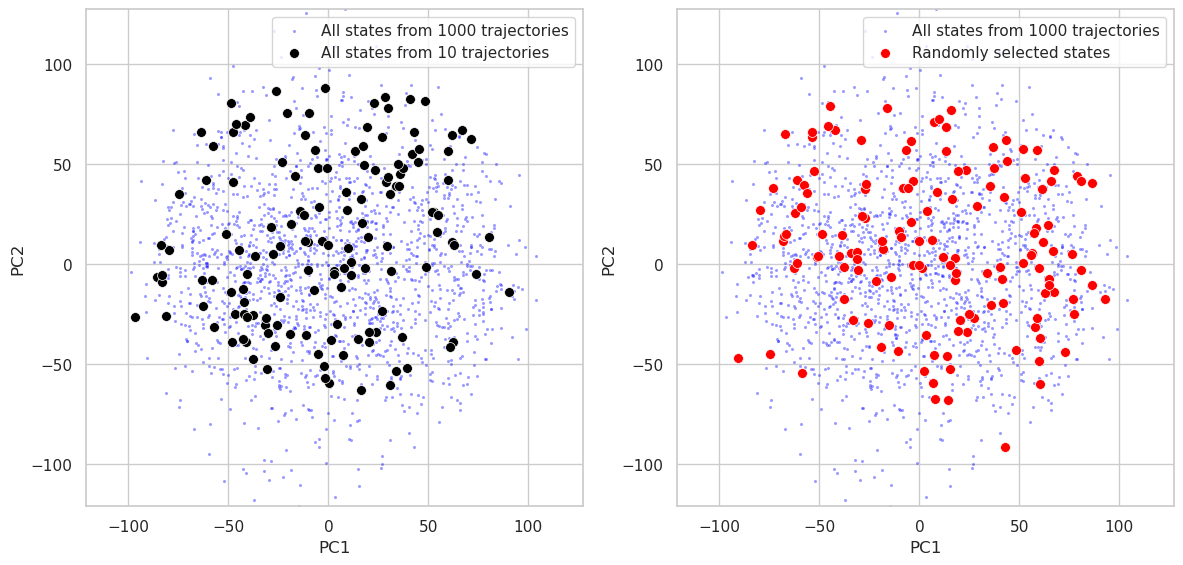

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch

# Assuming the previous setup (data preparation and PCA) remains the same
# Scatter plot using seaborn

# Set seaborn style for prettier plots
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Calculate the limits based on the data (both x and y should have the same limits)
min_limit = min(np.min(hiddens_transformed[:, 0]), np.min(hiddens_transformed[:, 1]))
max_limit = max(np.max(hiddens_transformed[:, 0]), np.max(hiddens_transformed[:, 1]))

# First plot: selected components in black, larger and with different transparency for blue
sns.scatterplot(ax=axes[0], x=hiddens_transformed[:, 0], y=hiddens_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
sns.scatterplot(ax=axes[0], x=hiddens_transformed[selected, 0], y=hiddens_transformed[selected, 1], color='black', s=50, edgecolor='white', linewidth=0.5, label='All states from 10 trajectories')  # larger black dots with white edge
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].set_xlim(min_limit, max_limit)
axes[0].set_ylim(min_limit, max_limit)

# Second plot: selected_scattered components in red, larger with edge color
sns.scatterplot(ax=axes[1], x=hiddens_transformed[:, 0], y=hiddens_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
sns.scatterplot(ax=axes[1], x=hiddens_transformed[selected_scattered, 0], y=hiddens_transformed[selected_scattered, 1], color='red', s=50, edgecolor='white', linewidth=0.5, label='Randomly selected states')  # larger red dots with white edge
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend()
axes[1].set_xlim(min_limit, max_limit)
axes[1].set_ylim(min_limit, max_limit)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
